In [25]:
import src.ptmodel as ptm
import src.geotools as gt
import src.densenet as dn
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.stats import gaussian_kde
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
pointlist8517=gt.sample_im_pixels(200000,'data/8517_4params.tif')
pointslist8744=gt.sample_im_pixels(200000,'data/8744_4params.tif')
pointslist83F2=gt.sample_im_pixels(200000,'data/83F2_4params.tif')
masterpoints=pointlist8517+pointslist8744+pointslist83F2

ddrsamples=gt.grab_raster_values('data/P12_005773_0849_XN_84S045W_ddr_final.img',points=pointlist8517,neighbs=2,plotit=False)
ddrsamples.extend(gt.grab_raster_values('data/P12_005862_0934_XI_86S057W_ddr_final.img',points=pointslist8744,neighbs=2,plotit=False))
ddrsamples.extend(gt.grab_raster_values('data/P12_005728_0938_XI_86S002W_ddr_final.img',points=pointslist83F2,neighbs=2,plotit=False))

crismsamples=gt.grab_raster_values('data/8517_4params.tif',points=pointlist8517,neighbs=False,plotit=False)
crismsamples.extend(gt.grab_raster_values('data/8744_4params.tif',points=pointslist8744,neighbs=False,plotit=False))
crismsamples.extend(gt.grab_raster_values('data/83F2_4params.tif',points=pointslist83F2,neighbs=False,plotit=False))

ctxsamples=gt.grab_raster_values('data/P12_005773_0849_XN_84S045W_final.img',points=pointlist8517,neighbs=2,plotit=False)
ctxsamples.extend(gt.grab_raster_values('data/P12_005862_0934_XI_86S057W_final.img',points=pointslist8744,neighbs=2,plotit=False))
ctxsamples.extend(gt.grab_raster_values('data/P12_005728_0938_XI_86S002W_final.img',points=pointslist83F2,neighbs=2,plotit=False))
print(len(ctxsamples),len(crismsamples),len(ddrsamples))
# datadict={'DDR':ddrsamples,'CTX':ctxsamples,'CRISM':crismsamples,'COORDS':masterpoints}
# iceds=ptm.ICEsDataset(datadict)
# iceds.normalize(catddr=False)
# train_loader,val_loader=ptm.gen_split(iceds,batchsize=1500)

600000 600000 600000


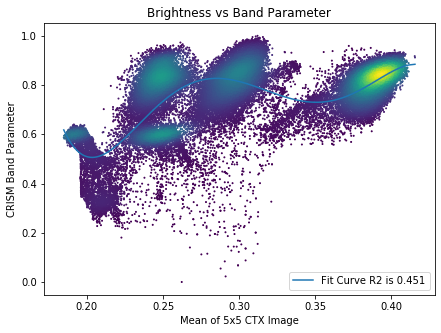

In [6]:
plt.figure(figsize=(7,5))
meanlist,ylist=[],[]
for i in range(len(iceds)):
    sample = iceds[i]
    sampmean=np.mean(sample['X'])
    meanlist.append(sampmean)
    ylist.append(sample['Y'][0])
xy = np.vstack([meanlist,ylist])
z = gaussian_kde(xy)(xy)    
plt.scatter(meanlist,ylist,c=z,s=1)
sortinds=np.argsort(meanlist)
fitcoeffs=np.polyfit(meanlist,ylist,5)
fitcurve=np.polyval(fitcoeffs,meanlist)
r2=r2_score(ylist,fitcurve)
plt.plot(np.array(meanlist)[sortinds],fitcurve[sortinds],label='Fit Curve R2 is '+ str(np.around(r2,3)))
plt.legend()
plt.xlabel('Mean of 5x5 CTX Image')
plt.ylabel('CRISM Band Parameter')
plt.title('Brightness vs Band Parameter')
plt.show()

In [3]:
import pickle
dictlist=[iceds.crismnorm,iceds.ctxnorm,iceds.ddrnorm]
outdict={}
for d in dictlist:
    outdict.update(d)
with open('models/IcesV1_normvals_noddr.pickle','wb') as f:
    pickle.dump(outdict,f)

In [ ]:
nbepoch=15

use_cuda = torch.cuda.is_available()
torch.manual_seed(1234)
device = torch.device("cuda" if use_cuda else "cpu")
model = ptm.Net().to(device)
print(model)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(str(params) +' Total Model Parameters.')

optimizer = torch.optim.Adadelta(model.parameters(), lr=1 )

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=.7)

trloss_list=[]
tstloss_list=[]
for epoch in range(1, 15):
    trloss=ptm.train_epoch(model, device, train_loader, optimizer, epoch,retloss=True)
    tstloss=ptm.test(model, device, val_loader,retloss=True)
    if trloss:
        trloss_list.append(trloss)
        tstloss_list.append(tstloss)
    scheduler.step()    # learning rate scheduler
plt.plot(np.arange(1,15), trloss_list, label='Training Loss', linestyle='-', color='blue')
plt.plot(np.arange(1,15), tstloss_list, label='Validation Loss', linestyle='--', color='red')
plt.legend()
plt.title('Training Curves of Vanilla CNN')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.eval()
with torch.no_grad():   # For the inference step, gradient is not computed
        for batch_idx, data in enumerate(val_loader):
            data, target = data['X'].to(
              device, dtype=torch.float), data['Y'].to(device, dtype=torch.float)
            output = model(data)
            pred=output.cpu().numpy()[:,0]
            targnp=target.cpu().numpy()[:,0]
            plt.scatter(pred,targnp)
            plt.title('R2 is '+ str(r2_score(pred,targnp)))

(array([2413864., 2122563., 7795968., 1904782., 3522643., 2310389.,
        1107238., 2674207., 5473478.,   74868.]),
 array([0.18039216, 0.20666667, 0.23294118, 0.25921569, 0.2854902 ,
        0.31176471, 0.33803922, 0.36431373, 0.39058824, 0.41686275,
        0.44313725]),
 <a list of 10 Patch objects>)

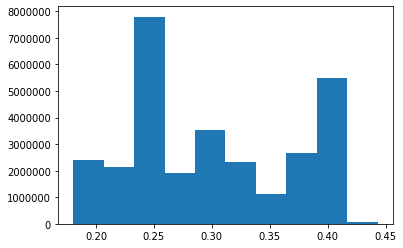

In [10]:
plt.hist(iceds.ctx.flatten())

(18000, 1, 7, 7) (18000, 4) (18000, 8, 7, 7)
(18000, 9, 7, 7)
(18000, 9, 7, 7) (18000, 4) (18000, 8, 7, 7)
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(9, 112, kernel_size=(2, 2), stride=(1, 1), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(112, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (transition1): _Transition

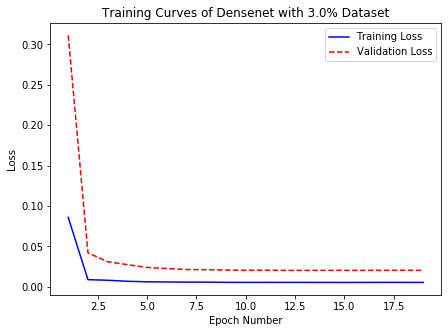

(5, 500, 4) (5, 500, 4)
(2500, 4) (2500, 4)


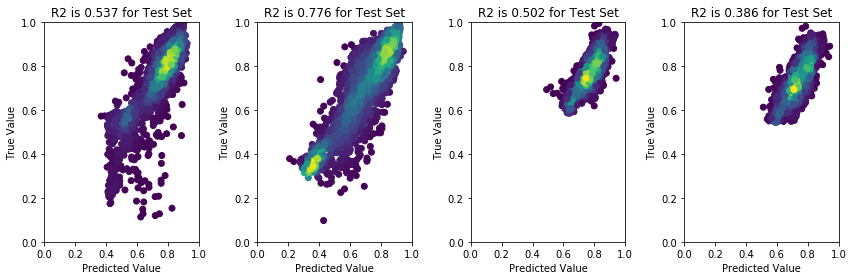

(60000, 1, 7, 7) (60000, 4) (60000, 8, 7, 7)
(60000, 9, 7, 7)
(60000, 9, 7, 7) (60000, 4) (60000, 8, 7, 7)
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(9, 112, kernel_size=(2, 2), stride=(1, 1), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(112, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (transition1): _Transition

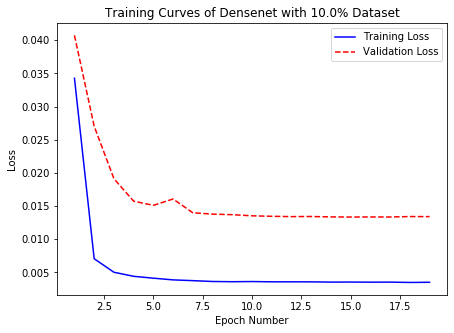

(17, 500, 4) (17, 500, 4)
(8500, 4) (8500, 4)


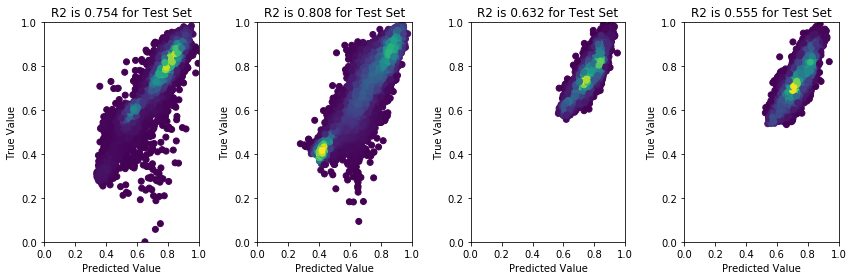

(180000, 1, 7, 7) (180000, 4) (180000, 8, 7, 7)
(180000, 9, 7, 7)
(180000, 9, 7, 7) (180000, 4) (180000, 8, 7, 7)
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(9, 112, kernel_size=(2, 2), stride=(1, 1), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(112, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (transition1): _Tra

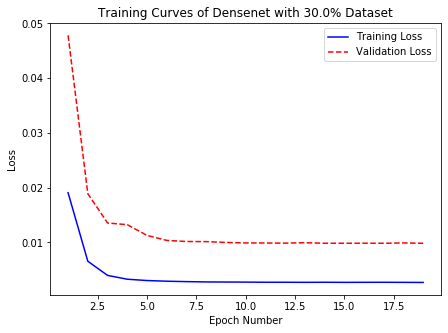

(53, 500, 4) (53, 500, 4)
(26500, 4) (26500, 4)


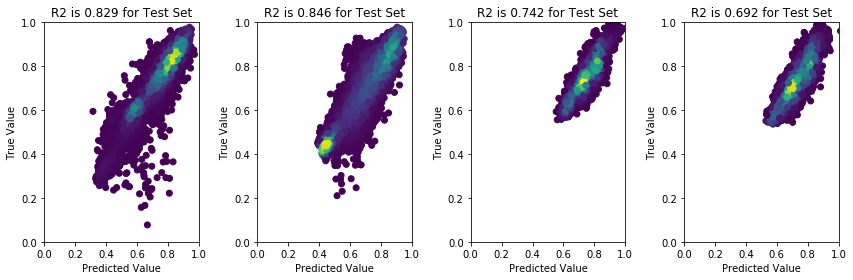

(600000, 1, 7, 7) (600000, 4) (600000, 8, 7, 7)
(600000, 9, 7, 7)
(600000, 9, 7, 7) (600000, 4) (600000, 8, 7, 7)
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(9, 112, kernel_size=(2, 2), stride=(1, 1), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(112, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (transition1): _Tra

Train Epoch: 18 [500000/510000 (98%)]	Loss: 0.002031
Train Epoch: 19 [0/510000 (0%)]	Loss: 0.002280
Train Epoch: 19 [250000/510000 (49%)]	Loss: 0.001849
Train Epoch: 19 [500000/510000 (98%)]	Loss: 0.001909


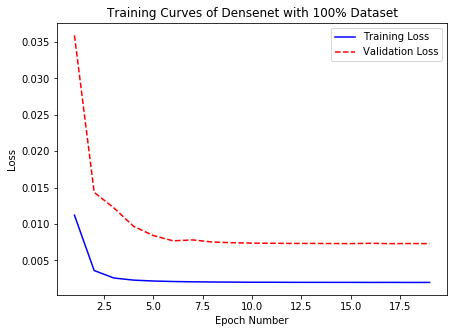

(179, 500, 4) (179, 500, 4)
(89500, 4) (89500, 4)


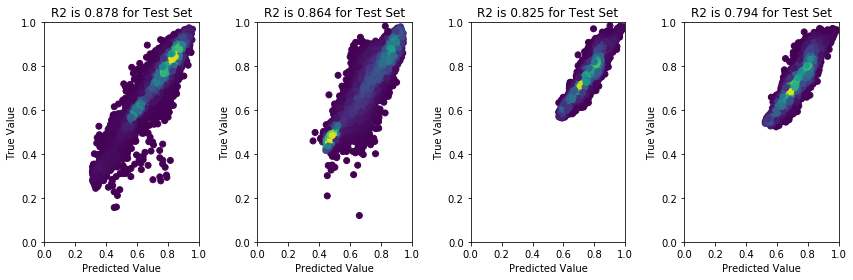

In [33]:
randinds=np.arange(0,len(ddrsamples),1)
np.random.shuffle(randinds)
ddrsamples,ctxsamples,crismsamples,masterpoints=np.array(ddrsamples)[randinds],np.array(ctxsamples)[randinds], \
                                                np.array(crismsamples)[randinds],np.array(masterpoints)[randinds]
for dspct in [.03,.1,.3,1]:
    stop=int(len(ddrsamples)*dspct)
    
    datadict={'DDR':ddrsamples[:stop],'CTX':ctxsamples[:stop],'CRISM':crismsamples[:stop],'COORDS':masterpoints[:stop]}
    iceds=ptm.ICEsDataset(datadict)
    iceds.normalize(catddr=True)
    train_loader,val_loader=ptm.gen_split(iceds,batchsize=500)
    nbepoch=20
    torch.cuda.empty_cache()
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(1234)
    device = torch.device("cuda")
    model = dn.DenseNet(growth_rate=16, block_config=(1, 2, 2, 3),
                     num_init_features=112, bn_size=1, drop_rate=0,
                     num_classes=iceds.crism.shape[1], memory_efficient=False,
                     ctxdim=9).to(device)
    print(model)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(str(params) +' Total Model Parameters.')

    optimizer = torch.optim.Adadelta(model.parameters(), lr=1)

    # Set your learning rate scheduler
    scheduler = StepLR(optimizer, step_size=1,gamma=.7)

    trloss_list=[]
    tstloss_list=[]
    for epoch in range(1, nbepoch):
        trloss=ptm.train_epoch(model, device, train_loader, optimizer, epoch,retloss=True)
        tstloss=ptm.test(model, device, val_loader,retloss=True)
        if trloss:
            trloss_list.append(trloss)
            tstloss_list.append(tstloss)
        scheduler.step()    # learning rate scheduler
    plt.figure(figsize=(7,5))
    plt.plot(np.arange(1,nbepoch), trloss_list, label='Training Loss', linestyle='-', color='blue')
    plt.plot(np.arange(1,nbepoch), tstloss_list, label='Validation Loss', linestyle='--', color='red')
    plt.legend()
    plt.title('Training Curves of Densenet with ' + str(dspct*100) +'% Dataset')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()
    plt.close()
    model.eval()
    r2s=[]
    fig,ax=plt.subplots(1,iceds.crism.shape[1],figsize=(12,4))
    mastpreds,masttargs=[],[]
    with torch.no_grad():   # For the inference step, gradient is not computed
            for batch_idx, data in enumerate(val_loader):
                targnp=data['Y'].numpy()
                data = data['X'].to(
                  device, dtype=torch.float)
                output = model(data)
                pred=output.cpu().numpy()
                subr2s=[]
                mastpreds.append(pred)
                masttargs.append(targnp)
    mastpreds,masttargs=np.array(mastpreds[:-1]),np.array(masttargs[:-1])
    print(mastpreds.shape,masttargs.shape)
    mastpreds=np.reshape(mastpreds,(mastpreds.shape[0]*mastpreds.shape[1],iceds.crism.shape[1]))
    masttargs=np.reshape(masttargs,(masttargs.shape[0]*masttargs.shape[1],iceds.crism.shape[1]))
    print(mastpreds.shape,masttargs.shape)
    for axind in range(iceds.crism.shape[1]):
        x,y=mastpreds[:,axind].flatten()[:10000], masttargs[:,axind].flatten()[:10000]
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax[axind].scatter(x,y,c=z)
        ax[axind].set_title('R2 is '+ str(np.around(r2_score(x,y),3)) +' for Test Set')
        ax[axind].set_xlabel('Predicted Value')
        ax[axind].set_ylabel('True Value')
        ax[axind].set_xlim(0,1)
        ax[axind].set_ylim(0,1)
    fig.tight_layout()
    plt.show()
#     torch.save(model.state_dict(), 'models/IcesV1_noddr.pt')

RMSE is 0.0014605625


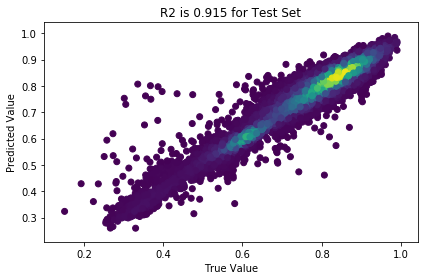

In [28]:
fig,ax=plt.subplots(1,iceds.crism.shape[1],figsize=(6,4))
for axind in range(iceds.crism.shape[1]):
        x,y=mastpreds[:,axind].flatten()[:10000], masttargs[:,axind].flatten()[:10000]
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax.scatter(y,x,c=z)
        ax.set_title('R2 is '+ str(np.around(r2_score(x,y),3)) +' for Test Set')
        print('RMSE is ' + str(mean_squared_error(y,x)))
        ax.set_ylabel('Predicted Value')
        ax.set_xlabel('True Value')
fig.tight_layout()
plt.show()

(60, 1500, 1) (60, 1500, 1)
(90000, 1) (90000, 1)


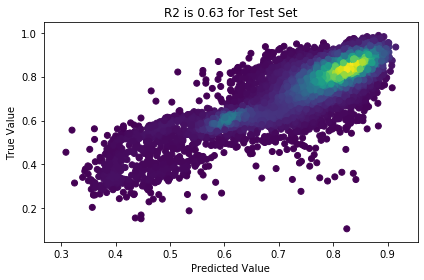

In [20]:
model.eval()
r2s=[]
fig,ax=plt.subplots(1,iceds.crism.shape[1],figsize=(6,4))
mastpreds,masttargs=[],[]
with torch.no_grad():   # For the inference step, gradient is not computed
        for batch_idx, data in enumerate(val_loader):
            targnp=data['Y'].numpy()
            data = data['X'].to(
              device, dtype=torch.float)
            output = model(data)
            pred=output.cpu().numpy()
            subr2s=[]
            mastpreds.append(pred)
            masttargs.append(targnp)
mastpreds,masttargs=np.array(mastpreds),np.array(masttargs)
print(mastpreds.shape,masttargs.shape)
mastpreds=np.reshape(mastpreds,(mastpreds.shape[0]*mastpreds.shape[1],iceds.crism.shape[1]))
masttargs=np.reshape(masttargs,(masttargs.shape[0]*masttargs.shape[1],iceds.crism.shape[1]))
print(mastpreds.shape,masttargs.shape)
for axind in range(iceds.crism.shape[1]):
    x,y=mastpreds[:,axind].flatten()[:10000], masttargs[:,axind].flatten()[:10000]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax.scatter(x,y,c=z)
    ax.set_title('R2 is '+ str(np.around(r2_score(x,y),3)) +' for Test Set')
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('True Value')
fig.tight_layout()
plt.show()
torch.save(model.state_dict(), 'models/IcesV1_noddr.pt')

In [16]:
# train_loader,val_loader=ptm.gen_split(iceds,batchsize=4000)
torch.cuda.empty_cache()
model.eval()
with torch.no_grad():   # For the inference step, gradient is not computed
        for batch_idx, data in enumerate(val_loader):
            data, target = data['X'].to(
              device, dtype=torch.float), data['Y'].to(device, dtype=torch.float)
            output = model(data)
            pred=output.cpu().numpy()[:,0]
            targnp=target.cpu().numpy()[:,0]
            xy = np.vstack([pred,targnp])
            z = gaussian_kde(xy)(xy)
            plt.scatter(pred,targnp,c=z)
            plt.title('R2 is '+ str(np.around(r2_score(pred,targnp),3)) +' for Train Set')
            plt.xlabel('Predicted Value')
            plt.ylabel('True Value')

TypeError: 'DataLoader' object is not subscriptable